In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from sklearn.model_selection import train_test_split
import src.lib.utility_classfier as uclf

In /Users/juan/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/juan/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/juan/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## loading the data

In [2]:
data_path='data/benchmark/'

In [3]:
df = pd.read_csv(path.join(data_path,'data.csv'))
df.shape

(109490, 89)

In [4]:
np.std(df.AGE)

14.655147758200552

In [5]:
np.mean(df[df.Class==1].AGE)

57.19900244299674

In [6]:
np.mean(df[df.Class==0].AGE)

46.40742078542331

In [7]:
def case_contro_ratio(y):
    num_of_case = y[y==1].shape[0]
    num_of_control = y[y==0].shape[0]
    ratio = num_of_control/num_of_case
    return ratio, num_of_case, num_of_control

In [8]:
print('Intersect ratio %.2f, case %d, control %d'% (case_contro_ratio(df)[0],case_contro_ratio(df)[1], case_contro_ratio(df)[2]))

Intersect ratio 1.00, case 109490, control 109490


## prepare the data for machine learning

In [9]:
y=df.Class.values #outcome
data = df.drop(['GRID','Class'], axis=1) # data that will be used for training
feature_list=data.columns.tolist()
# X=np.load(path.join(data_path,'phemed_binary_value/X.npy'))
X = data.values
# X=np.load(path.join(data_path,'phemed_binary_value/X.npy'))
X.shape

(109490, 87)

In [10]:
# randomly select the training and testing data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train num',X_train.shape[0])
print('X_test num',X_test.shape[0])

X_train num 87592
X_test num 21898


## Training and assesment

In [11]:
import xgboost as xgb
import src.lib.utility_classfier as uclf

param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 100
xgtrain = xgb.DMatrix(X_train, y_train)
xgtest = xgb.DMatrix(X_test)

bst = xgb.train(param, xgtrain, num_round)

/Users/juan/anaconda/lib/python3.6/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/juan/anaconda/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/juan/anaconda/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


[15:20:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




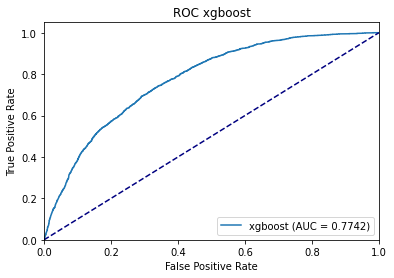

In [12]:
# make prediction and assess the model
preds = bst.predict(xgtest)
uclf.compute_roc(y_test,preds,'xgboost')

In [13]:
pos_ratio = case_contro_ratio(y_test)[1]/y_test.shape[0]

Average precision-recall score: 0.24


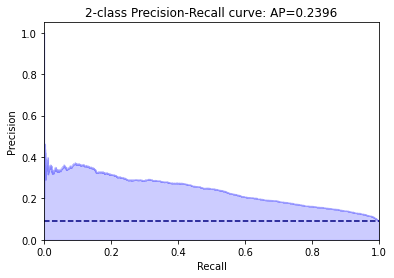

In [14]:
# plot the  PRC Curve
uclf.plot_prc(y_test,preds,pos_ratio)

/Users/juan/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.2606257783066533
0.2574337233756442
Classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19953
           1       0.38      0.03      0.06      1945

    accuracy                           0.91     21898
   macro avg       0.64      0.51      0.50     21898
weighted avg       0.87      0.91      0.87     21898

Confusion_matrix
[[19855    98]
 [ 1886    59]]
done in 1.290221s
(1, 87)
1. feature DURATION_BF2007 (8.209930)
2. feature AGE (3.156887)
3. feature MAX_SYSTOLIC (1.638634)
4. feature MAX_DIASTOLIC (1.563482)
5. feature MAX_VALUE_Creat (1.188310)
6. feature MAX_VALUE_Chol (1.117137)
7. feature MAX_BMI (1.053842)
8. feature MEDIAN_VALUE_Chol (1.041300)
9. feature MIN_VALIE_Creat (1.027072)
10. feature MAX_VALUE_HDL-C (0.801882)
11. feature MAX_VALUE_LDL-C (0.788003)
12. feature MIN_VALIE_Chol (0.774528)
13. feature MEDIAN_VALUE_Creat (0.761978)
14. feature CNT_395 (0.720345)
15. feature CNT_425 (0.654248)
1

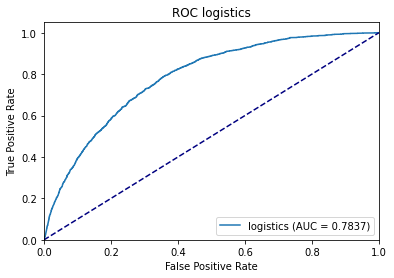

In [15]:
import sklearn.preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
max_abs_scaler = preprocessing.MaxAbsScaler()
X_train_scaled = max_abs_scaler.fit_transform(X_train)
X_test_scaled = max_abs_scaler.transform(X_test)
y_score = uclf.logic_regression(X_train_scaled, y_train,X_test_scaled, y_test,10,feature_list,20)
uclf.compute_roc(y_test,y_score,'logistics')

Average precision-recall score: 0.25


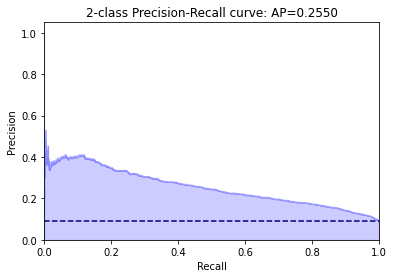

In [16]:
uclf.plot_prc(y_test,y_score,pos_ratio)

In [17]:
y_score = uclf.random_forest(X_train, y_train,X_test, y_test,feature_list,20)

Classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19953
           1       0.67      0.00      0.01      1945

    accuracy                           0.91     21898
   macro avg       0.79      0.50      0.48     21898
weighted avg       0.89      0.91      0.87     21898

Confusion_matrix
[[19950     3]
 [ 1939     6]]
done in 28.718340s
1. feature DURATION_BF2007 (0.052964)
2. feature AGE (0.041591)
3. feature MAX_BMI (0.033389)
4. feature MEDIAN_BMI (0.033213)
5. feature MIN_BMI (0.033128)
6. feature MAX_SYSTOLIC (0.030691)
7. feature STD_BMI (0.028689)
8. feature MEDIAN_SYSTOLIC (0.028433)
9. feature MIN_SYSTOLIC (0.026545)
10. feature MAX_DIASTOLIC (0.025214)
11. feature MEDIAN_DIASTOLIC (0.025044)
12. feature MIN_DIASTOLIC (0.024514)
13. feature MAX_VALUE_Gluc (0.023272)
14. feature STD_DIASTOLIC (0.021714)
15. feature MAX_VALUE_Trigs (0.021683)
16. feature STD_SYSTOLIC (0.021638)
17. feature STD_VALUE_Glu

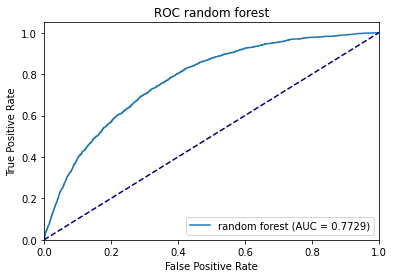

In [18]:
uclf.compute_roc(y_test,y_score,'random forest')

Average precision-recall score: 0.24


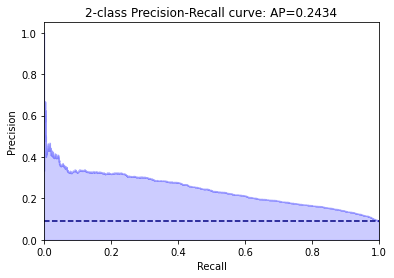

In [19]:
uclf.plot_prc(y_test,y_score,pos_ratio)

Classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19953
           1       0.41      0.02      0.03      1945

    accuracy                           0.91     21898
   macro avg       0.66      0.51      0.49     21898
weighted avg       0.87      0.91      0.87     21898

Confusion_matrix
[[19905    48]
 [ 1912    33]]
done in 81.406248s
1. feature AGE (0.300506)
2. feature CNT_272 (0.090177)
3. feature CNT_MedCode_1191 (0.089207)
4. feature CNT_401 (0.072051)
5. feature DURATION_BF2007 (0.059293)
6. feature Smoking (0.029864)
7. feature CNT_395 (0.025127)
8. feature STD_VALUE_Creat (0.023837)
9. feature CNT_101 (0.018639)
10. feature STD_VALUE_Trigs (0.016486)
11. feature CNT_MedCode_408081 (0.016403)
12. feature MAX_BMI_missing (0.016045)
13. feature MAX_VALUE_Creat (0.013652)
14. feature MIN_BMI (0.013182)
15. feature MAX_VALUE_Trigs (0.011925)
16. feature CNT_425 (0.010642)
17. feature MAX_SYSTOLIC (0.01036

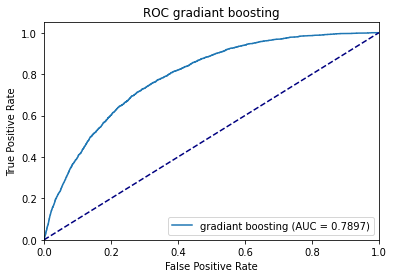

In [20]:
y_score = uclf.gradiant_boosting(X_train, y_train,X_test, y_test,feature_list,20)
uclf.compute_roc(y_test,y_score,'gradiant boosting')

Average precision-recall score: 0.26


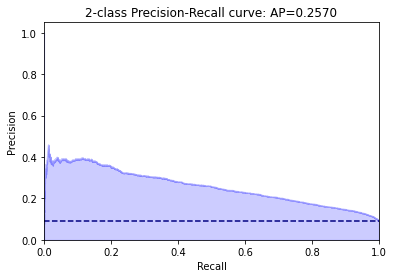

In [21]:
uclf.plot_prc(y_test,y_score,pos_ratio)

## feature selection by L1 

In [22]:
#feature selection by L1 
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_new = model.transform(X_train)
print(X_train_new.shape)
X_test_new = model.transform(X_test)
print(X_test_new.shape)

(87592, 64)
(21898, 64)


/Users/juan/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## feature selection with Trees

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train)

In [24]:
model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)
print(X_train_new.shape)
X_test_new = model.transform(X_test)
print(X_test_new.shape)

(87592, 42)
(21898, 42)


In [25]:
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)
importances = clf.feature_importances_ 
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 4 (0.030035)
2. feature 3 (0.027090)
3. feature 14 (0.026446)
4. feature 15 (0.025823)
5. feature 13 (0.025456)
6. feature 19 (0.025043)
7. feature 18 (0.024777)
8. feature 17 (0.024776)
9. feature 21 (0.023627)
10. feature 23 (0.023133)


0.2666668610899587
0.2633589232075808
Classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19953
           1       0.41      0.01      0.02      1945

    accuracy                           0.91     21898
   macro avg       0.66      0.50      0.49     21898
weighted avg       0.87      0.91      0.87     21898

Confusion_matrix
[[19929    24]
 [ 1928    17]]
done in 0.800225s
(1, 42)
1. feature Race_B (9.346415)
2. feature GENDER (3.060897)
3. feature MAX_VALUE_Chol_missing (2.114748)
4. feature AGE (2.069060)
5. feature MAX_SYSTOLIC (1.222994)
6. feature MAX_VALUE_HDL-C_missing (1.172948)
7. feature STD_DIASTOLIC (1.147072)
8. feature MEDIAN_SYSTOLIC (1.130918)
9. feature MAX_VALUE_Gluc (1.022435)
10. feature MAX_DIASTOLIC (0.885370)
11. feature STD_BMI (0.858858)
12. feature MAX_VALUE_Creat (0.808787)
13. feature MAX_BMI (0.755207)
14. feature MIN_VALIE_HDL-C (0.516641)
15. feature MAX_VALUE_LDL-C_missing (0.50

/Users/juan/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


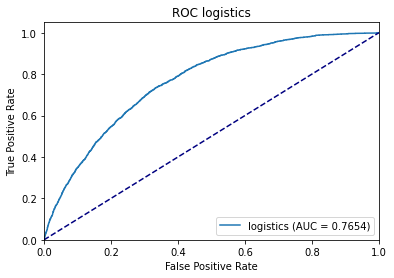

In [26]:
#logica regression with selected features
X_train_new_scaled = max_abs_scaler.fit_transform(X_train_new)
X_test_new_scaled = max_abs_scaler.transform(X_test_new)
y_score = uclf.logic_regression(X_train_new_scaled, y_train,X_test_new_scaled, y_test,10,feature_list,20)
uclf.compute_roc(y_test,y_score,'logistics')

## feature selection with lasso

In [27]:
#feature selection by Lassocv
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
clf = LassoCV(n_alphas=1000).fit(X_train, y_train)
model = SelectFromModel(clf,prefit=True)
X_train_new = model.transform(X_train)
print(X_train_new.shape)
X_test_new = model.transform(X_test)
print(X_test_new.shape)
print(clf.coef_.argsort()[::-1][:20])

(87592, 11)
(21898, 11)
[ 3 47 14 22 27 48 36 30  4 86 24 25 26 28 29 33 31 32 34 35]


In [28]:
np.sort(clf.coef_)[::-1][:20]

array([ 3.02585249e-03,  8.24185480e-04,  8.16632568e-04,  2.35985950e-04,
        2.03355260e-04,  7.89262307e-05,  4.71064525e-05,  3.10853472e-05,
        1.27726162e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00])

/Users/juan/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.2734659342583549
0.26964990200629657
Classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19953
           1       0.28      0.00      0.01      1945

    accuracy                           0.91     21898
   macro avg       0.59      0.50      0.48     21898
weighted avg       0.86      0.91      0.87     21898

Confusion_matrix
[[19940    13]
 [ 1940     5]]
done in 1.001416s
(1, 11)
1. feature Race_B (10.677051)
2. feature GENDER (3.589287)
3. feature MAX_BMI_missing (3.258019)
4. feature Race_W (1.951304)
5. feature Smoking (1.942769)
6. feature MAX_VALUE_Gluc_missing (1.762786)
7. feature DURATION_BF2007 (1.717574)
8. feature AGE (1.540567)
9. feature MAX_VALUE_HDL-C_missing (-0.154061)
10. feature MAX_VALUE_Chol_missing (-1.857538)


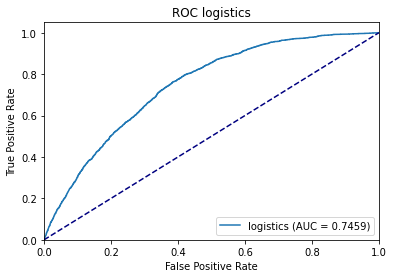

In [29]:
#logica regression with selected features
X_train_new_scaled = max_abs_scaler.fit_transform(X_train_new)
X_test_new_scaled = max_abs_scaler.transform(X_test_new)
y_score = uclf.logic_regression(X_train_new_scaled, y_train,X_test_new_scaled, y_test,10,feature_list,10)
uclf.compute_roc(y_test,y_score,'logistics')